In [29]:
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


<h1>Checking for Duplicates and Nulls</h1>

In [7]:

if df.iloc[: ,0].nunique() == df.shape[0]:
    print('There are no duplicates')
else:
    print('There are some duplicates')

if df.isnull().sum().sum() == 0:
    print('There are no null values')
else:
    print('There are some null values')

There are no duplicates
There are no null values


### Control and Exposed Groups

In [22]:
contorl_num = df.groupby('experiment').agg({'auction_id': 'count'})['auction_id']['control']
exposed_num  = df.groupby('experiment').agg({'auction_id': 'count'})['auction_id']['exposed']

print(f"Control: {contorl_num}")
print(f"Exposed: {exposed_num}")


Control: 4071
Exposed: 4006


In [34]:
reduced_df = df[['auction_id', 'experiment', 'yes', 'no']]
reduced_df = reduced_df.query("not (yes == 0 & no == 0)")
reduced_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})

reduced_df_agg = reduced_df.groupby("experiment").agg({"yes": "sum", "no":"sum"})
reduced_df_agg['aware'] = [0,0]
reduced_df_agg['aware']['control'] = reduced_df_agg['yes']['control']
reduced_df_agg['aware']['exposed'] = reduced_df_agg['yes']['exposed']

reduced_df_agg['total'] = [0, 0]
reduced_df_agg['total']['control'] = reduced_df_agg['yes']['control'] +  reduced_df_agg['no']['control']
reduced_df_agg['total']['exposed'] = reduced_df_agg['yes']['exposed'] + reduced_df_agg['no']['exposed']

print(f"control group: {reduced_df_agg['aware']['control']}")
print(f"exposed group: {reduced_df_agg['aware']['exposed']}")

test_df = reduced_df_agg.copy()
test_df

control group: 264
exposed group: 308


,yes,no,aware,total
experiment,,,,
control,264,322,264,586
exposed,308,349,308,657


In [25]:
control_conversion_rate = test_df['aware']['control'] / test_df['total']['control']
exposed_conversion_rate = test_df['aware']['exposed'] / test_df['total']['exposed']

print(f" The conversion rate of control group is {control_conversion_rate:0.2f}")
print(f" The conversion rate of exposed group is {exposed_conversion_rate:0.2f}")

 The conversion rate of control group is 0.45
 The conversion rate of exposed group is 0.47


In [35]:
diff = exposed_conversion_rate - control_conversion_rate

variance_contorl = control_conversion_rate * (1 - control_conversion_rate)
variance_exposed = exposed_conversion_rate * (1 - exposed_conversion_rate)

### calculating the standard error

In [36]:
contorl_total = reduced_df_agg['total']['control']
exposed_total = reduced_df_agg['total']['exposed']

standar_err_control = np.sqrt(variance_contorl)/np.sqrt(contorl_total)
standar_err_exposed = np.sqrt(variance_exposed)/np.sqrt(exposed_total)

In [28]:
shift  = (exposed_conversion_rate - control_conversion_rate) / control_conversion_rate


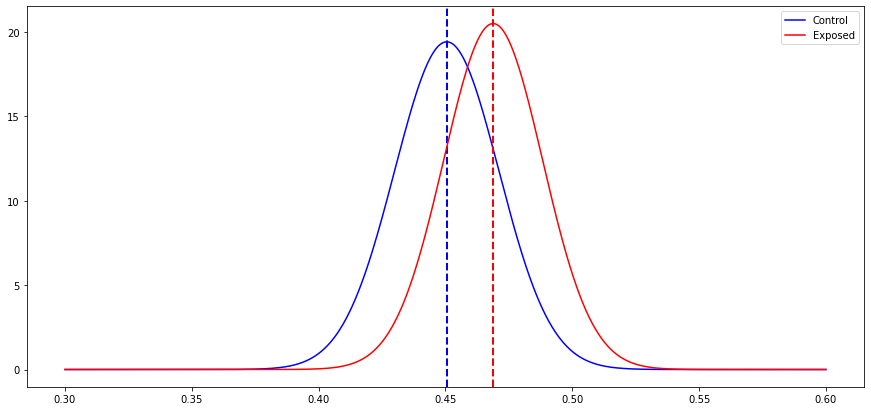

In [42]:
fig, ax = plt.subplots(figsize=(15,7))

x = np.linspace(0.3, 0.6, 1000)

ctr_rate_prob = scs.norm(control_conversion_rate, standar_err_control).pdf(x)
ax.plot(x, ctr_rate_prob, label='Control', color='blue')
ax.axvline(x=control_conversion_rate, c='blue', linestyle='dashed', linewidth=2)



exposed_rate_prob = scs.norm(exposed_conversion_rate, standar_err_exposed).pdf(x)
ax.plot(x, exposed_rate_prob, label='Exposed', color='red')
ax.axvline(x=exposed_conversion_rate, c='red', linestyle='dashed', linewidth=2)
plt.legend()

## Hence, the awareness of the exposed group is higher than that of the control group.

### Is the increase in awareness siginificant?

In [46]:

def significance(control_rate, exposed_rate, control_total, exposed_total, alpha=0.05, tail="one"):
    diff = exposed_rate - control_rate
    
    A_variance =  control_rate * (1 - control_rate)
    B_variance  = exposed_rate * (1 - exposed_rate)
    
    z_score = diff / np.sqrt((A_variance/control_total) + (B_variance/exposed_total))

    p_value  = scs.norm().sf(z_score)
    
    if (tail == "one"):
        compare = alpha
    else:
        comapre = alpha / 2
        
    return abs(p_value) < alpha, p_value, z_score
        


In [47]:
alpha = 1 - 0.95

is_signi, p_value, z_score = significance(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total, alpha=alpha)


z_score = diff / np.sqrt((variance_contorl/contorl_total) + (variance_exposed/exposed_total))
print (f"z score is {z_score:0.2f}" )

p_value  = scs.norm().sf(z_score)
print (f"p value is {p_value:0.2f}" )

is_signi, p_value, z_score = significance(control_conversion_rate, exposed_conversion_rate,
                                            contorl_total, exposed_total)

print(f"Significance: {is_signi}")


z score is 0.65
p value is 0.26
Significance: False


### Since our P_value > 0.05, our increase in awarness is not significant. Therefore, we reject our alternative hypothesis.